<a href="https://colab.research.google.com/github/jinchen1036/DataScience_Project/blob/master/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [0]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_set1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
test_set2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)

In [4]:
concanate_df = pd.concat([train_df,test_set1_df])
print("Combine df shape: ",concanate_df.shape)

Combine df shape:  (14000, 38)


In [5]:
numeric_df = concanate_df.select_dtypes(include=[np.number])
print("Combine numeric df shape: ",numeric_df.shape)

Combine numeric df shape:  (14000, 29)


In [6]:
all_value_df = numeric_df.dropna(axis=1)
all_value_df['rent'] = numeric_df['rent']
print("Combine no null value numeric df shape: ",all_value_df.shape)

Combine no null value numeric df shape:  (14000, 25)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
columns = list(all_value_df.columns)
columns.remove('rent')
columns.append('const')
all_value_df = sm.add_constant(all_value_df)
est = sm.OLS(all_value_df['rent'],
             all_value_df[columns].astype(float)).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     979.2
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:52:02   Log-Likelihood:            -1.2445e+05
No. Observations:               14000   AIC:                         2.489e+05
Df Residuals:                   13975   BIC:                         2.491e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
building_id            -2.28

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
feature_columns = ['bedrooms','bathrooms','size_sqft','addr_zip','has_elevator','has_fireplace','has_dishwasher','is_furnished','has_gym','allows_pets','has_washer_dryer','has_roofdeck','has_concierge','no_fee']


In [9]:
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [10]:
train_df = all_value_df.iloc[:12000]
test_df = all_value_df.iloc[12000:]
print("Train Shape: ", train_df.shape)
print("Test Shape: ", test_df.shape)

Train Shape:  (12000, 26)
Test Shape:  (2000, 26)


In [11]:
dtree=DecisionTreeClassifier(
    criterion='entropy',
    random_state=20191021,
    max_depth=50,
    #min_samples_split=2,
    #min_samples_leaf=1,
    #max_features=None,
    #max_leaf_nodes=None,
)

dtree.fit(train_df[feature_columns], train_df['rent'])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=20191021, splitter='best')

In [0]:
# Visualization
dot_data = StringIO()
export_graphviz(dtree,
                out_file=dot_data,
                filled=True,
                rounded=True,
                feature_names=feature_columns,
                special_characters=True
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [12]:
pred_survival = dtree.predict(train_df[feature_columns])

print('Train mean_squared_error:   %0.3f' % mean_squared_error(train_df.rent, pred_survival))

Train mean_squared_error:   37278.488


In [13]:
pred_survival = dtree.predict(test_df[feature_columns])

print('Test mean_squared_error:   %0.3f' % mean_squared_error(test_df.rent, pred_survival))

Test mean_squared_error:   3049997.342


In [14]:
train_df.index

Int64Index([7236931, 7331920, 7139224, 7364827, 7242151, 7171210, 7286986,
            7418503, 7304773, 7180240,
            ...
            7214185, 7360534, 7398904, 7222669, 7177303, 7411030, 7397836,
            7154701, 7259554, 7422694],
           dtype='int64', name='rental_id', length=12000)

In [0]:
# Test for CV
k_fold = KFold(n_splits=5, random_state=20181105,shuffle=False)

def get_cv_results(classifier):
    results = []
    for train, test in k_fold.split(train_df[feature_columns]):
        classifier.fit(train_df.loc[train_df.index[train], feature_columns], train_df.loc[train_df.index[train], 'rent'])
        y_predicted = classifier.predict(train_df.loc[train_df.index[test], feature_columns])
        loss = mean_squared_error(train_df.loc[train_df.index[test], 'rent'], y_predicted)
        results.append(loss)
        # print(loss)
    return np.mean(results), np.std(results)

In [0]:
dtree = DecisionTreeClassifier(
    criterion='entropy',
    random_state=20180408,
    max_depth=50,
)

In [21]:
result = get_cv_results(dtree)
# k = k_fold.split(train_df[feature_columns])

3760957.0370833334
2491120.9166666665
3302082.75125
2086218.2775
2873354.5745833335


In [25]:
depth_values = range(10, 200, 10)
all_depth_mu = []
all_depth_sigma = []

for m in depth_values:
    dtree = DecisionTreeClassifier(
        criterion='entropy',
        random_state=20180408,
        # min_samples_split=m,
        max_depth=m,
        # min_samples_leaf=m,
        # max_features=m,
        # max_leaf_nodes=m,
    )

    mu, sigma = get_cv_results(dtree)
    all_depth_mu.append(mu)
    all_depth_sigma.append(sigma)

    print(m, mu, sigma)

10 2945691.7098333337 748189.2737775174
20 2625489.4396666666 769186.9449568001
30 2902746.7114166664 588729.583390585
40 2902746.7114166664 588729.583390585
50 2902746.7114166664 588729.583390585
60 2902746.7114166664 588729.583390585
70 2902746.7114166664 588729.583390585
80 2902746.7114166664 588729.583390585
90 2902746.7114166664 588729.583390585
100 2902746.7114166664 588729.583390585
110 2902746.7114166664 588729.583390585
120 2902746.7114166664 588729.583390585
130 2902746.7114166664 588729.583390585
140 2902746.7114166664 588729.583390585
150 2902746.7114166664 588729.583390585
160 2902746.7114166664 588729.583390585
170 2902746.7114166664 588729.583390585
180 2902746.7114166664 588729.583390585
190 2902746.7114166664 588729.583390585


Text(0.5, 0, 'Minimum Samples Per Leaf')

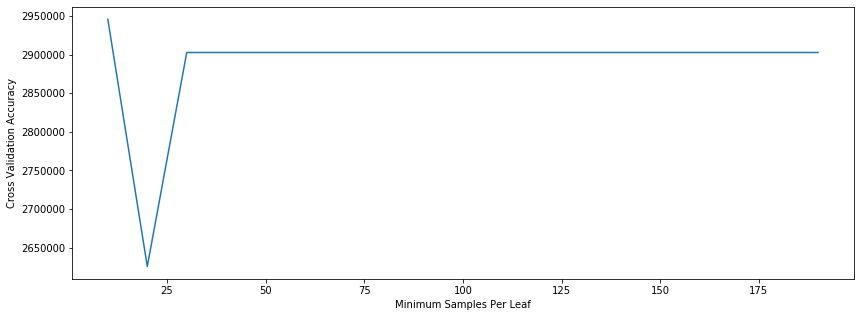

In [26]:
plt.figure(figsize=(14, 5))
plt.plot(depth_values, all_depth_mu)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Maximum Depth per Leaf')

In [28]:
split_values = range(25, 150, 25)
all_split_mu = []
all_split_sigma = []

for m in split_values:
    dtree = DecisionTreeClassifier(
        criterion='entropy',
        random_state=20180408,
        max_depth=20,
        min_samples_split=m,
        # min_samples_leaf=m,
        # max_features=m,
        # max_leaf_nodes=m,
    )

    mu, sigma = get_cv_results(dtree)
    all_split_mu.append(mu)
    all_split_sigma.append(sigma)

    print(m, mu, sigma)

25 3099206.028 719348.274846836
50 2994064.3969166665 925645.1772782601
75 3117829.425 876018.0548992485
100 2777349.82525 543980.39381378
125 2940024.198166667 534826.6447199726


Text(0.5, 0, 'Minimum Samples Per Leaf')

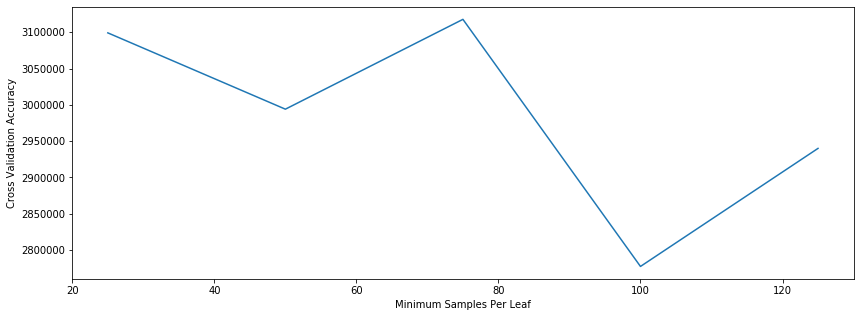

In [29]:
plt.figure(figsize=(14, 5))
plt.plot(split_values, all_split_mu)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Minimum Samples Per Leaf')

In [33]:
features_values = range(2, 15, 2)
all_features_mu = []
all_features_sigma = []

for m in features_values:
    dtree = DecisionTreeClassifier(
        criterion='entropy',
        random_state=20180408,
        max_depth=20,
        min_samples_split=100,
        # min_samples_leaf=m,
        max_features=m,
        # max_leaf_nodes=m,
    )

    mu, sigma = get_cv_results(dtree)
    all_features_mu.append(mu)
    all_features_sigma.append(sigma)

    print(m, mu, sigma)

2 5233821.390583334 1140204.6160898285
4 6404343.27075 3228646.205722867
6 4000406.949083333 1371161.2046707415
8 5666161.3292499995 3255140.468453604
10 3676525.032666667 1002908.1134481063
12 3452185.165666667 1032900.6945440092
14 2777349.82525 543980.39381378
